### **Generating Fair Predictions by Post Processing the Predictions of a Machine Learning Classifier Trained on Chest X-Rays**

##### **Task**
Post-process the predictions of a binary classifier's trained to predict the presence of cardiomegaly in chest x-rays to be fair with respect to sex

##### **Requirements**
1. Basic understanding of machine learning and deep learning
2. Programming in Python

##### **Learning Objectives**
1. Evaluate the fairness of a classifier's predictions on chest x-rays with respect to the sensititive attribute sex.
2. Implement the post-processing method outlined in the paper "Equality of Oppurtunity in Supervised Learning" by Moritz Hardt, Eric Price, and Nathan Srebro to generate fair predictions
2. Visualize the fairness of the classifier before and after post-processing

##### **Acknowledgements**
This Jupyter Notebook was based on code by the following people:
1. Beepul Bharti (bbharti1@jhu.edu)
2. Scott Lee (yle4@cdc.gov)

##### **Download the data and utils folder**

In [ ]:
import os
import shutil

user = "beepulbharti"
repo = "fairness_demo"

# remove local directory if it already exists
if os.path.isdir(repo):
    !rm -rf {repo}
!git clone https://github.com/{user}/{repo}.git

# remove local data if it already exists and update with new folder
dir = os.getcwd()
data_folder_old = os.path.join(repo,'data')
data_folder_new = os.path.join(dir,'data')
if os.path.isdir(data_folder_new):
    shutil.rmtree('data')
shutil.copytree(data_folder_old,data_folder_new)

# Add balancer.py and tool.py
shutil.copy(os.path.join(repo,'updated_balancers.py'),dir)
shutil.copy(os.path.join(repo,'updated_tools.py'),dir)

# Remove git repo folder
shutil.rmtree(repo)

Cloning into 'fairness_demo'...
remote: Enumerating objects: 51, done.
remote: Counting objects: 100% (51/51), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 51 (delta 19), reused 46 (delta 14), pack-reused 0
Receiving objects: 100% (51/51), 1.17 MiB | 7.70 MiB/s, done.
Resolving deltas: 100% (19/19), done.


##### **Load the data**

In [ ]:
import pandas as pd

# Define the paths to the csv files of the validation and test data
# The CSVs must contain the sensitive attribute A, label Y, and predicted label Y_hat for all samples
path_to_val_data = 'data/demo_validation_data.csv'
path_to_test_data = 'data/demo_test_data.csv'
val_data = pd.read_csv(path_to_val_data,index_col=[0])
test_data = pd.read_csv(path_to_test_data,index_col=[0])

##### **Display Example Images**
Diplay example chest x-rays along with the true and predicted labels of a:
1) A male does not have cardiomegaly
2) A female that does have cardiomegaly

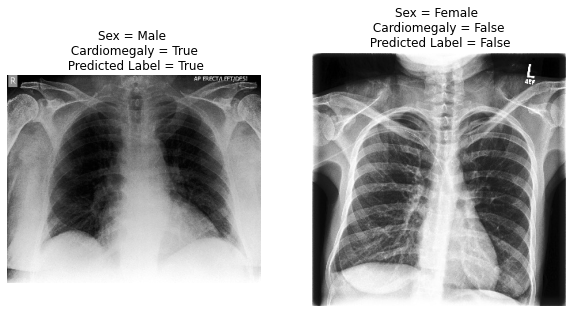

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

path_to_male_image = 'data/example_images/male_pos.jpg'
path_to_female_image = 'data/example_images/female_neg.jpg'
male_img = mpimg.imread(path_to_male_image)
female_img = mpimg.imread(path_to_female_image)

# Make figure
# create figure
fig = plt.figure(figsize=(10, 7))

# Adds a subplot at the 1st position
fig.add_subplot(1, 2, 1)
plt.imshow(male_img,cmap='gray')
plt.axis('off')
plt.title("Sex = Male \n Cardiomegaly = True \n Predicted Label = True")

# Adds a subplot at the 2nd position
fig.add_subplot(1, 2, 2)
plt.imshow(female_img,cmap='gray')
plt.axis('off')
plt.title("Sex = Female \n Cardiomegaly = False \n Predicted Label = False");

##### **Evaluate the Theoretical Fairness of the Classifier Predictions on the Test Set**
In supervised learning, the objective is, given labeled training data, to learn a predictor, $\hat{Y} = f(X)$, of the outcome $Y$ from features $X$. In many scenarios we also desire that $\hat{Y}$ is *fair* with respect to sensitive/protected attributes such as race, sex, color, etc. There are many definitions of fairness in supervised learning. In this demo, we consider the *Equalized Odds* definition in a binary classification setting. 

A classifier $\hat{Y}$ satisifies *equalized odds* with respect to a binary sensitive attribute $A \in \{0,1\}$ and outcome $Y$ if

$$
P[\hat{Y} = 1 | A = 1, Y = y] = P[\hat{Y} = 1 | A = 0, Y = y], \quad y \in \{0,1\}
$$

which simply states that $\hat{Y}$ has equal true postitive rates (TPR) and false positive rates (FPRs) across the two groups defined by $A = 0$ and $A=1$

Throughout this demo we will measure the fairness of $\hat{Y}$ through the following quantities

$$
bias_{TPR} = |P[\hat{Y} = 1 | A = 1, Y = 1] - P[\hat{Y} = 1 | A = 0, Y = 1]|
$$
$$
bias_{FPR} = |P[\hat{Y} = 1 | A = 1, Y = 0] - P[\hat{Y} = 1 | A = 0, Y =0]|
$$

Note that all of these quantities can be evaluated by simply having access to the predicted labels, true labels, and sex attributes. As a result, here we will rely on a model that has already been trained on a collection of images and that achieves an AUC of 0.85 for classifying cardiomegaly. For this demo we bring the predictions made by this model, $\hat{Y}$. We do this for the sake of generality: what follows presents a **post processing** procedure that can be used for different predictors trained on different data, as long as one simply provides the true labels, predicted labels, and protected attributes.

In [ ]:
import numpy as np
from updated_balancers import BinaryBalancer

# Set the variables a, y, and y_hat
a_test = test_data.a.values
y_test = test_data.y.values
y_hat_test = test_data.y_hat.values

# Use the Binary Balancer class to evaluate the violation of equalized odds
model = BinaryBalancer(a=a_test,y=y_test,y_=y_hat_test)
bias_tpr = np.abs(model.group_rates[1].tpr - model.group_rates[0].tpr)
bias_fpr = np.abs(model.group_rates[1].fpr - model.group_rates[0].fpr)

# Print bias_tpr and bias_fpr
print('bias_tpr = ', round(bias_tpr,3))
print('bias_fpr = ', round(bias_fpr,3))

bias_tpr =  0.091
bias_fpr =  0.082


##### **Visualize the Violation of Equalized Odds on the ROC Plane**

One can plot the coordinate, $(FPR, TPR)$, on the ROC plane for the groups $A = 0$ and $A = 1$ and observe the points are different, indicating that $\hat{Y}$ does NOT satisfy equalized odds.

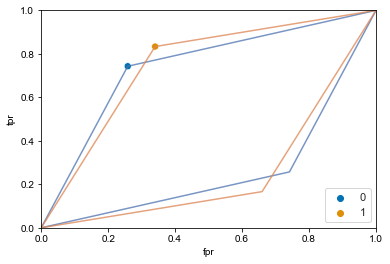

In [ ]:
# Plot the TPRs and FPRs for groups A=0 and A=1
model.plot(optimum=False)

##### **Learn a fair-model via post-processing on the validation dataset**

We would like to learn a predictor $\tilde{Y}$ that satisfies equalized odds and is accurate. Furthemore, in many settings, such as medical imaging, it is desirable if this task can be done *after* training because one may not have access to the training data or the model. All one could have is the sensitive attribute $A$, the true outcome $Y$ and predicted outcome $\hat{Y}$

One can still learn such a $\tilde{Y}$ by simply considering the probabilites

$$
p_{y,a} = P[\tilde{Y} = 1 | A = a, \hat{Y} = y], \quad y,a \in \{0,1\} 
$$

with are probabilites that one does (or does not) change the prediction $\hat{Y}$. Note these quantities fully describe $\tilde{Y}$ AND are **independent** of the true labels $Y$. Such a predictor is referred to as a *derived* predictor.

Thus, to learn $\tilde{Y}$ one can consider the optimization problem for some loss function $L$

$$
\min E[L(\tilde{Y},Y)]
$$
$$
s.t. \quad \tilde{Y} \ \text{is derived AND satisfies equalized odds}
$$

This problem is simply a linear program in the 4 quantities $p_{y,a}$ whose solution is $\tilde{Y}$ an optimal predictor that satisfies equalized odds.

In [ ]:
# Set the variables a, y, and y_hat
a_val = val_data.a.values
y_val = val_data.y.values
y_hat_val = val_data.y_hat.values

# Learn a fair model using the validation set by solving the linear program
val_model = BinaryBalancer(a=a_val,y=y_val,y_=y_hat_val)
val_model.adjust(imbalanced=True)


Post-adjustment group rates are 

 group    fpr    tpr
   0.0 0.3062 0.7502
   1.0 0.3047 0.7620

And loss is 0.2977



In [ ]:
# Generate fair y_hat on the test set using the fair model
y_hat_fair = val_model.predict(y_=y_hat_test,a=a_test)

# Check new values of bias_tpr and bias_fpr
fair_model = BinaryBalancer(a=a_test,y=y_test,y_=y_hat_fair)
bias_tpr = np.abs(fair_model.group_rates[1].tpr - fair_model.group_rates[0].tpr)
bias_fpr = np.abs(fair_model.group_rates[1].fpr - fair_model.group_rates[0].fpr)

# Print the bias_tpr and bias_fpr of the fair predictions, y_hat_fair, generated by the fair model
print('bias_tpr = ', round(bias_tpr,3))
print('bias_fpr = ', round(bias_fpr,3))

bias_tpr =  0.009
bias_fpr =  0.004


##### **Visualize the Optimal Point the Post-Processing Method Calculates to Achieve Equalized Odds on the ROC Plane**

One can then visualize the solution the coordinate $(FPR, TPR)$ of $\tilde{Y}$ and see the probabilites, $p_{y,a}$, which are the solutions to the linear program.

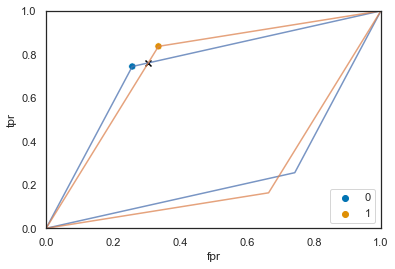

p_{0,0} =  0.06416344108278817
p_{1,0} =  1.0
p_{0,1} =  0.0
p_{1,1} =  0.9089543597382614


In [ ]:
# Plot the TPRs and FPRs for groups A=0 and A=1
val_model.plot(optimum=True)
solution = val_model.opt.x
print('p_{0,0} = ', solution[0])
print('p_{1,0} = ', solution[1])
print('p_{0,1} = ', solution[2])
print('p_{1,1} = ', solution[3])